## TODO Recording:

- Go to Drive
- Show that you have a folder called ai_workshop_dcgans/
- Click on it and show the folder called anime_classification/
- Click through to anime_classification/ and show the two subfolders
- Click through to the real_images - open up 3-4 images and show
- Click through to the bad_fake_images - open up 2-3 images from the im_5 series and show
- Then sort descending by name and - open up 2-3 images from the im_20 series and show

### Come to the notebook

- Show the runtime is GPU


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.utils import  make_grid

import numpy as np
import matplotlib.pyplot as plt

## TODO Recording

- Once you execute the cell below
- Open up the pane on the left and show that MyDrive is mounted

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Device is defined for Training


In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

device

device(type='cuda', index=0)

Creating a Dataset with two classes- Real images and Bad fake images.Note that all images are resized to 64,  CenterCropped , Converted to Tensor and Normalised

In [4]:
batch_size = 16
image_size = 64

# Create the dataset
anime_faces_dataset = dset.ImageFolder(
    root = '/content/drive/MyDrive/ai_workshop_dcgans/anime_classification/',
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

Both the classes comprises of 1024 images each

In [5]:
len(anime_faces_dataset)

480

Classes can be verified

In [6]:
classes = anime_faces_dataset.classes

classes

['bad_fake_images', 'images']

Splitting the dataset into train and test in approx. 80-20 ratio

In [7]:
train_set, test_set = torch.utils.data.random_split(anime_faces_dataset, [384, 96])

Creating training and testing dataloaders

In [8]:
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True, num_workers = 2
)


testloader = torch.utils.data.DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False, num_workers = 2
)

Checking the shape of one batch of training data

In [9]:
dataiter = iter(trainloader)

images, labels = next(dataiter)
images.shape

torch.Size([16, 3, 64, 64])

Visualising the images for both Bad fakes and Real images. Bad fakes are pretty easy to identify.

images images images images bad_fake_images images images images


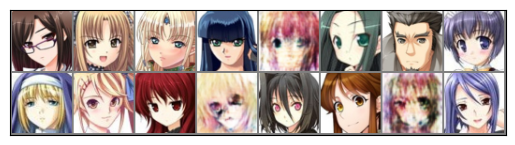

images images images bad_fake_images images images bad_fake_images images


In [10]:
def display(img):
    img = img / 2 + 0.5
    img = img.permute(1, 2, 0)
    npimg = img.numpy()

    plt.imshow(npimg)
    plt.xticks([])
    plt.yticks([])
    plt.show()

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

display(make_grid(images, 8))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))

In [11]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

Plotting some training images

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [12]:
def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Discriminator is defined which will be used for Image classification

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(
                in_channels = nc,
                out_channels = ndf,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(
                in_channels = ndf,
                out_channels = ndf * 2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(
                in_channels = ndf * 2,
                out_channels = ndf * 4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(
                in_channels = ndf * 4,
                out_channels = ndf * 8,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(
                in_channels = ndf * 8,
                out_channels = 1,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

Discriminator is instantiated. Applying the 'weights_init' function to randomly initialize all weights like this: `to mean=0, stdev=0.2`. Discriminator Model architecture is printed

In [14]:
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Initializing the ``BCELoss`` function and optimizer

In [15]:
criterion = nn.BCELoss()

optimizer = optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.999))

Train the network
 We simply  looping over our data iterator, and feed the inputs to the network and optimize.

In [16]:
for epoch in range(2):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = netD(inputs)

        loss = criterion(outputs.flatten(), labels.float())
        loss.backward()

        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 20==0:    # print every 20 mini-batches
            print(f'[Epoch: {epoch + 1}, Step: {i + 1:5d}] loss: {running_loss/20:.3f}')
            running_loss = 0.0

print('Finished Training')

[Epoch: 1, Step:     1] loss: 0.052
[Epoch: 1, Step:    21] loss: 0.308
[Epoch: 2, Step:     1] loss: 0.000
[Epoch: 2, Step:    21] loss: 0.003
Finished Training


Testing the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Displaying a batch of image from the test set to get familiar.

GroundTruth: 
images images images images images images images images


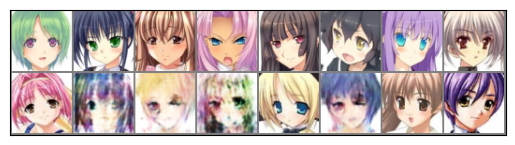

images bad_fake_images bad_fake_images bad_fake_images images bad_fake_images images images


In [17]:
dataiter = iter(testloader)

images, labels = next(dataiter)

print('GroundTruth: ')

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
display(make_grid(images, 8))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))

In [18]:
outputs = netD(images.to(device))

Predicted: 
images images images images images images images images


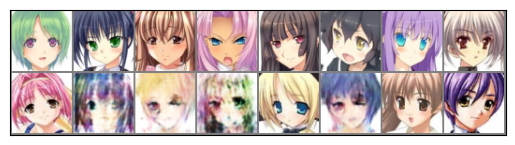

images bad_fake_images bad_fake_images bad_fake_images images bad_fake_images images images


In [19]:
predicted = torch.round(outputs.flatten())


print('Predicted: ')

print(' '.join(f'{classes[predicted.long()[j]]:5s}' for j in range(8)))
display(make_grid(images, 8))
print(' '.join(f'{classes[predicted.long()[j]]:5s}' for j in range(8, 16)))

Checking performance on whole test set.Discriminator after training can easily identify Bad fake images and real images.

In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = netD(images)

        predicted = torch.round(outputs.flatten()).long()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 98 %


Class wise performances is checked

In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = netD(images)

        predictions = torch.round(outputs.flatten()).long()

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: bad_fake_images is 96.3 %
Accuracy for class: images is 100.0 %
